In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn import metrics
%matplotlib inline

In [2]:
df_org = pd.read_csv("/../home/tweet/dataset/apartemangermany/immo_data.csv", 
                  usecols=['serviceCharge', 'heatingType', 'telekomUploadSpeed', 'totalRent']
                )

In [3]:
df = df_org.copy()

In [4]:
df.columns

Index(['serviceCharge', 'heatingType', 'telekomUploadSpeed', 'totalRent'], dtype='object')

In [5]:
df.head(2)

,serviceCharge,heatingType,telekomUploadSpeed,totalRent
0,245.0,central_heating,10.0,840.0
1,134.0,self_contained_central_heating,10.0,NaN


In [6]:
df.shape

(268850, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   serviceCharge       261941 non-null  float64
 1   heatingType         223994 non-null  object 
 2   telekomUploadSpeed  235492 non-null  float64
 3   totalRent           228333 non-null  float64
dtypes: float64(3), object(1)
memory usage: 8.2+ MB


# Cleansing

In [8]:
for col in df.columns:
    print(col," =>", df[col].isnull().sum()/len(df[col])*100)

serviceCharge  => 2.5698344801934163
heatingType  => 16.68439650362656
telekomUploadSpeed  => 12.407662265203644
totalRent  => 15.070485400781106


In [9]:
df.serviceCharge.fillna(df.serviceCharge.median(), inplace=True)
df.heatingType.fillna(df.heatingType.mode()[0], inplace=True)
df.telekomUploadSpeed.fillna(df.telekomUploadSpeed.median(), inplace=True)
df.totalRent.fillna(df.totalRent.median(), inplace=True)

In [10]:
df.describe()

,serviceCharge,telekomUploadSpeed,totalRent
count,268850.000000,268850.000000,2.688500e+05
mean,150.789643,30.193975,8.634546e+02
std,304.319451,15.729180,3.063164e+04
min,0.000000,1.000000,0.000000e+00
25%,96.000000,10.000000,4.950000e+02
50%,135.000000,40.000000,6.500000e+02
75%,185.000000,40.000000,9.000000e+02
max,146118.000000,100.000000,1.575154e+07


# Outliers

In [11]:
# Return unbiased kurtosis over requested axis using Fisher's definition of kurtosis (kurtosis of normal == 0.0).
# The result is normalized by N-1
kurt = df.kurt(numeric_only=True)[:]
kurt

serviceCharge         197151.674512
telekomUploadSpeed        -0.765917
totalRent             260044.391607
dtype: float64

In [12]:
outliers = ['serviceCharge', 'totalRent']

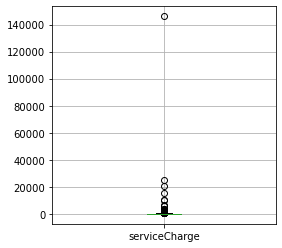

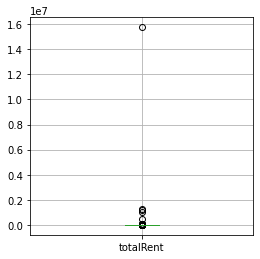

In [13]:
for col in outliers:
    plt.figure(figsize=(4, 4))
    df.boxplot(column=[col])

In [14]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [15]:
for col in outliers:
    print(f'{col}: {len(outliers_iqr(df[col])[0])}')

serviceCharge: 10271
totalRent: 20025


In [16]:
def outliers_z_score(ys):
    threshold = 3
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [17]:
for col in outliers:
    print(f'{col}: {len(outliers_z_score(df[col])[0])}')

serviceCharge: 98
totalRent: 6


In [18]:
for i in outliers:
    quartile_1, quartile_3 = np.percentile(df[i], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    df = df[df[i]<upper_bound]
    df = df[df[i]>lower_bound]

In [19]:
#for i in outliers:
#     mean_y = np.mean(df[i])
#     stdev_y = np.std(df[i])
#     lower_bound = mean_y - (3 * stdev_y)
#     upper_bound = mean_y + (3 * stdev_y)
#     df = df[df[i]<upper_bound]
#     df = df[df[i]>lower_bound]

In [20]:
df.heatingType.value_counts()

central_heating                   159389
district_heating                   22260
gas_heating                        18191
self_contained_central_heating     18058
floor_heating                      12100
oil_heating                         4642
heat_pump                           2175
combined_heat_and_power_plant       1519
night_storage_heater                1322
electric_heating                     871
wood_pellet_heating                  780
stove_heating                        335
solar_heating                        128
Name: heatingType, dtype: int64

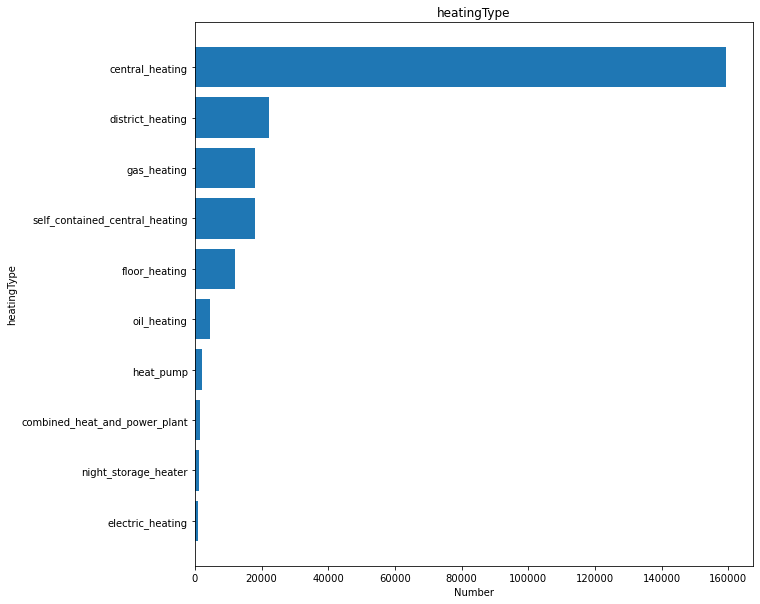

In [21]:
plt.figure(figsize=(10, 10))
data = df.heatingType.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("heatingType")
plt.ylabel("heatingType")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

In [22]:
def filter(x):
    if x in [
    'oil_heating', 'combined_heat_and_power_plant', 'heat_pump', 'night_storage_heater', 
    'wood_pellet_heating', 'electric_heating', 'stove_heating', 'solar_heating'
] :
        x = 'other'
        return x
    else:
        return x
df.heatingType = df.heatingType.apply(filter)

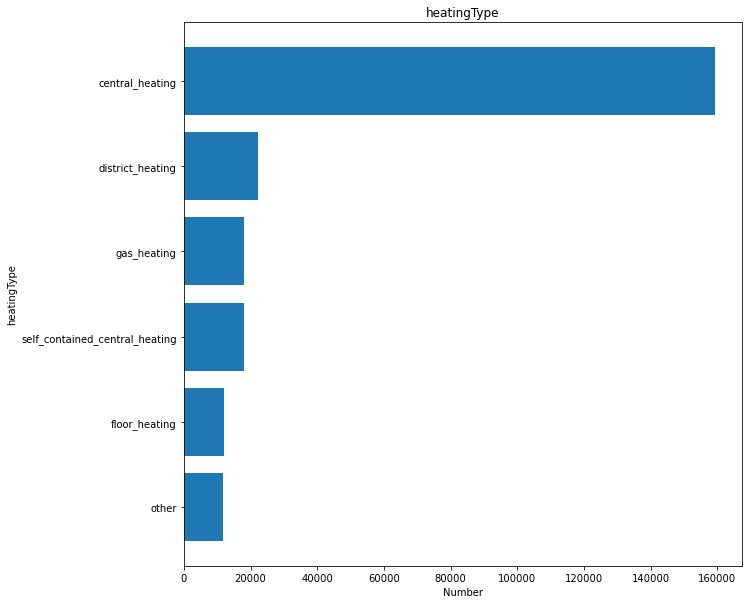

In [23]:
plt.figure(figsize=(10, 10))
data = df.heatingType.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("heatingType")
plt.ylabel("heatingType")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

# Preprocessing

In [24]:
df.columns

Index(['serviceCharge', 'heatingType', 'telekomUploadSpeed', 'totalRent'], dtype='object')

In [25]:
y = df.pop('totalRent')
X = df

In [26]:
y = pd.DataFrame(data=y, columns=['totalRent'])

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

y_train.head(3)

,totalRent
163884,1197.0
170230,438.5
139873,650.0


In [28]:
X_train.shape

(193416, 3)

In [29]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ss = StandardScaler()

In [30]:
preprocessor_x = ColumnTransformer(
    transformers=[
            ('serviceCharge', ss, ['serviceCharge']),
            ('telekomUploadSpeed', ss, ['telekomUploadSpeed']),
            ('heatingType', ohe, ['heatingType']),       
])

preprocessor_y = ColumnTransformer(
    transformers=[
            ('totalRent', ss, ['totalRent']),    
])

In [31]:
fitter_y = preprocessor_y.fit(y_train)
fitter_x = preprocessor_x.fit(X_train)

In [32]:
y_train = fitter_y.transform(y_train)
y_test = fitter_y.transform(y_test)
X_train = fitter_x.transform(X_train)
X_test = fitter_x.transform(X_test)

In [43]:
print(f'train x shape: {X_train.shape}')
print(f'train y shape: {y_train.shape}')
print(f'test x shape: {X_test.shape}')
print(f'test y shape: {y_test.shape}')


train x shape: (200, 8)
train y shape: (200, 1)
test x shape: (48354, 8)
test y shape: (48354, 1)


# Scratch

In [305]:
# Linear reggression
class Net() :   
    def __init__( self, learning_rate=0.01 , iterations=1000 , method='mse') :
        self.learning_rate = learning_rate
        self.iterations = iterations 
        self.method = method

    
    # Function for model training        
    def fit( self, X, Y ) : 
        # no_of_training_examples, no_of_features
        self.m, self.n = X.shape 
        # weight initialization 
        self.W = np.random.rand( self.n ) 
        self.b = 0 
        self.X = X 
        self.Y = Y 
        # gradient descent learning         
        for i in range( self.iterations ) :
            self.update_weights(X, Y)  
        return self
    
    
    # Helper function to update weights in gradient descent 
    def update_weights( self, X, Y ) :
        Y_pred = self.predict( X )
        
        # calculate gradients
        
        # Linear reggression with minimum square error
        if self.method == 'mse':
            se = (Y.T - Y_pred) 
            se = se.T
            dW = - ( 2 * ( X.T ).dot( se )  ) / self.m
            db = - 2 * np.sum( se ) / self.m
            
        # Linear reggression with minimum absolute error
        elif self.method == 'ae':
            se = abs(Y.T - Y_pred) / 2
            se = se.T
            dW = - ( 2 * ( X.T ).dot( se )  ) / self.m
            db = - 2 * np.sum( se ) / self.m
        
        # Linear reggression with Epsilon Sensitive Error
        elif self.method == 'ese':
            pass
        
        dW = np.asarray(dW)
        dW = dW.reshape(8,)
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db 
        return self
    
    # Hypothetical function  h( x )  
    def predict( self, X ) :
        return (X.dot( self.W ) + self.b)

# Linear reggression with minimum square error

In [306]:
model_mse = Net(method='mse')

In [307]:
model_mse.fit(X_train, y_train)

In [308]:
print(model_mse.W)
print(model_mse.b)
y_pre_test_mse = model_mse.predict(X_test)
y_pre_test_mse = y_pre_test_mse.reshape(-1, 1)
print('linear reggression R^2: test', metrics.r2_score(y_test, y_pre_test_mse))

[0.51247643 0.02328637 0.21860312 0.32390868 0.82613084 0.31798014
 0.52988338 0.43039462]
-0.2978064240488342
linear reggression R^2: test 0.31302322636645297


# Linear reggression with Absolute Error

In [309]:
model_ae = Net(method='ae')

In [310]:
model_ae.fit(X_train, y_train)

In [311]:
print(model_ae.W)
print(model_ae.b)
y_pre_test_ae = model_ae.predict(X_test)
y_pre_test_ae = y_pre_test_ae.reshape(-1, 1)
print('linear reggression R^2: test', metrics.r2_score(y_test, y_pre_test_ae))

[ -30374.33713449    5316.33906653 1483312.36910077  124995.18500957
   65066.47647775  100655.30614147   63786.53331883  100814.875013  ]
1938627.421773713
linear reggression R^2: test -9099424453779.033


# Linear reggression with Epsilon Sensitive Error

In [312]:
# Linear reggression with Epsilon Sensitive Error
model_mse = Net(method='ese')

# Sklearn pakage

# LinearRegression

In [313]:
model_lr = LinearRegression()

In [314]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [315]:
print('linear reggression Variance score train:', model_lr.score(X_train, y_train))

linear reggression Variance score train: 0.3122037348182187


In [316]:
y_pred_test = model_lr.predict(X_test)

In [317]:
print('linear reggression R^2: test', metrics.r2_score(y_test, y_pred_test))

linear reggression R^2: test 0.31555708149383144


# Lasso

In [318]:
model_lasso = Lasso()

In [319]:
model_lasso.fit(X_train, y_train)

Lasso()

In [320]:
print('lasso Variance score train:', model_lasso.score(X_train, y_train))

lasso Variance score train: 0.0


In [321]:
y_pred_test_lasso = model_lasso.predict(X_test)

In [322]:
print('lasso reggression R^2: test', metrics.r2_score(y_test, y_pred_test_lasso))

lasso reggression R^2: test -1.8593291330137873e-05


# Ridge

In [323]:
model_ridge = Ridge()

In [324]:
model_ridge.fit(X_train, y_train)

Ridge()

In [325]:
print('Ridge Variance score train:', model_ridge.score(X_train, y_train))

Ridge Variance score train: 0.31224185234182733


In [326]:
y_pred_test_ridge = model_ridge.predict(X_test)

In [327]:
print('ridge reggression R^2: test', metrics.r2_score(y_test, y_pred_test_ridge))

ridge reggression R^2: test 0.3155681632081635
